## TRY TO VISUALIZE MODEL RESULTS IN CONTEXT OF OTHER ESTUARIES

PROBLEM - limited estuary data, sometimes missing T, depth...

In [103]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Mythical code button"></form>''')

In [104]:
import arrow
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
plt.style.use('classic')
from matplotlib.patches import Rectangle
import pickle
from cmocean import cm
import warnings
import netCDF4 as nc
import sys
sys.path.append('../pyscripts/bylayer_extract/')
import extract_bylayer_mean_BOXMASK as ebmBOX 
from importlib import reload
from salishsea_tools import viz_tools

import sys
sys.path.append('/data/tjarniko/mocsy')
import mocsy

%matplotlib inline
warnings.simplefilter('ignore')

plt.rcParams.update({'font.size': 13,
                     'xtick.labelsize' : 13,
                     'ytick.labelsize' : 13})

In [105]:

def calculate_Egleston_factors(ttemp, tsal, talk, tdic_A, dep, del_dic):

    tdic_B = tdic_A + del_dic
    
    tzero = np.zeros_like(tdic_A)
    
    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_A, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_A,pco2_A,fco2,co2_A,hco3,co3,OmegaA_A,OmegaC,BetaD,DENis,p,Tis = response_tup

    response_tup = mocsy.mvars(temp=ttemp, sal=tsal, alk=talk, dic=tdic_B, 
                           sil=tzero, phos=tzero, patm=tzero+1, depth=dep, lat=tzero, 
                            optcon='mol/m3', optt='Tinsitu', optp='m',
                            optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')

    pH_B,pco2_B,fco2,co2_B,hco3,co3,OmegaA_B,OmegaC,BetaD,DENis,p,Tis = response_tup

    omega_DIC = 1/((np.log(OmegaA_B)-np.log(OmegaA_A))/(del_dic))
    
    Hplus_A = 10**(-1*pH_A); Hplus_B = 10**(-1*pH_B)
    beta_DIC = 1/((np.log(Hplus_B)-np.log(Hplus_A))/(del_dic))
    
    gamma_DIC = 1/((np.log(co2_B)-np.log(co2_A))/(del_dic))
    
    return omega_DIC, beta_DIC, gamma_DIC



In [106]:
df = pd.read_csv('./data_papers/estuaries.csv')

## Display dataframe

In [107]:
df

,Paper,Paper_code,Estuary,Bordering_Ocean,Season,DIC,TA,S,T,depth,"Datasource (0= numbers 1= calc from rel, 2 = estimated from paper figure",Fig_reference_notes
0,Zhai_2007,1,Yangtze,East China Sea,winter,2050.000,2100.000,0.0000,NaN,NaN,2,fig3- km minus50 estimate
1,Zhai_2007,1,Yangtze,East China Sea,spring,2000.000,2100.000,0.0000,NaN,NaN,2,fig3 - km minus50
2,Zhai_2007,1,Yangtze,East China Sea,autumn,1800.000,1850.000,3.0000,NaN,NaN,2,fig3 - km 0
3,Zhai_2007,1,Yangtze,East China Sea,spring,1800.000,1850.000,3.0000,NaN,NaN,2,fig3 - km 0
4,Zhai_2007,1,Yangtze,East China Sea,winter,1900.000,1950.000,10.0000,NaN,NaN,2,fig3 - km 0
5,Proum_2018,2,Brunei,South China Sea,?,677.650,230.900,0.0000,NaN,NaN,1,Calc from fig 7 relationship
6,Proum_2018,2,Brunei,South China Sea,?,872.700,536.650,5.0000,NaN,NaN,1,Calc from fig 7 relationship TA = 230.9+ 61.15...
7,Proum_2018,2,Brunei,South China Sea,?,1067.750,842.400,10.0000,NaN,NaN,1,Calc from fig 7 relationship
8,Proum_2018,2,Brunei,South China Sea,?,1457.850,1453.900,20.0000,NaN,NaN,1,Calc from fig 7 relationship
9,Gonski_2017,3,Delaware Bay,Atlantic,Summer - 01jun,1628.464,1806.445,21.8281,23.9199,6.565,0,depth = pressure dbar


## DISPLAY JDF AND CS2 STATIONS. COULD MOVE CS2 STATION EAST, TO GET MORE FRESH WATER...

Text(0.5, 1.0, 'individual stations')

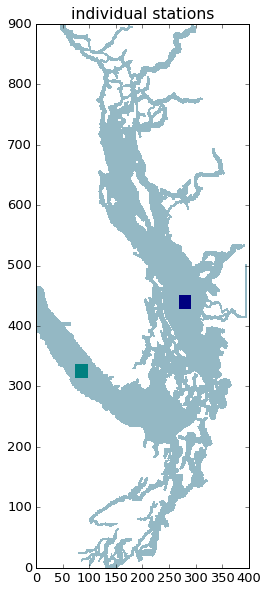

In [108]:
jdf_x = 85; jdf_y = 325; jdf_col = 'teal'
cs2_x = 280; cs2_y = 440; cs2_col = 'navy'


w = nc.Dataset('/data/tjarniko/results/hindcast.201905_dayavg_OmA-pH-pCO2/OmA_plus_20070104.nc')
pco2 = w['model_output']['pCO2'][:]
pco2[pco2>2e5] = np.nan
pco2[pco2<2000] = 500
fact = 1.5
fig = plt.figure(figsize=(12*fact,6.5*fact))

ax0 = fig.add_subplot(1,2,1)
#toba and bute

im = ax0.pcolormesh(pco2, cmap=cm.balance_r, vmin = 0, vmax = 800)
viz_tools.set_aspect(ax0)
#jdf
rect_jdf = Rectangle((jdf_x-10,jdf_y-10),20,20,linewidth=2,edgecolor=jdf_col,facecolor=jdf_col)
ax0.add_patch(rect_jdf)

rect_cs = Rectangle((cs2_x-10,cs2_y-10),20,20,linewidth=2,edgecolor=cs2_col,facecolor=cs2_col)
ax0.add_patch(rect_cs)

ax0.set_title('individual stations')



#### LOAD MODEL DATA AND CALCULATE BUFFER FACTORS

In [109]:
BR3_DIC_jdf = pickle.load(open('../pkls/BR3_DIC_means_jdf_BOX.pkl','rb'))
BR3_TA_jdf = pickle.load(open('../pkls/BR3_TA_means_jdf_BOX.pkl','rb'))
BR3_sal_jdf = pickle.load(open('../pkls/BR3_sal_means_jdf_BOX.pkl','rb'))
BR3_temp_jdf = pickle.load(open('../pkls/BR3_temp_means_jdf_BOX.pkl','rb'))

PI4_DIC_jdf = pickle.load(open('../pkls/PI4_DIC_means_jdf_BOX.pkl','rb'))
PI4_TA_jdf = pickle.load(open('../pkls/PI4_TA_means_jdf_BOX.pkl','rb'))
PI4_sal_jdf = pickle.load(open('../pkls/PI4_sal_means_jdf_BOX.pkl','rb'))
PI4_temp_jdf = pickle.load(open('../pkls/PI4_temp_means_jdf_BOX.pkl','rb'))

BR3_DIC_cs2 = pickle.load(open('../pkls/BR3_DIC_means_cs2_BOX.pkl','rb'))
BR3_TA_cs2 = pickle.load(open('../pkls/BR3_TA_means_cs2_BOX.pkl','rb'))
BR3_sal_cs2 = pickle.load(open('../pkls/BR3_sal_means_cs2_BOX.pkl','rb'))
BR3_temp_cs2 = pickle.load(open('../pkls/BR3_temp_means_cs2_BOX.pkl','rb'))

PI4_DIC_cs2 = pickle.load(open('../pkls/PI4_DIC_means_cs2_BOX.pkl','rb'))
PI4_TA_cs2 = pickle.load(open('../pkls/PI4_TA_means_cs2_BOX.pkl','rb'))
PI4_sal_cs2 = pickle.load(open('../pkls/PI4_sal_means_cs2_BOX.pkl','rb'))
PI4_temp_cs2 = pickle.load(open('../pkls/PI4_temp_means_cs2_BOX.pkl','rb'))



BR3_DIC_cs2_summer =np.nanmean(BR3_DIC_cs2[:,152:244], axis = 1)
BR3_TA_cs2_summer = np.nanmean(BR3_TA_cs2[:,152:244], axis = 1)
BR3_sal_cs2_summer = np.nanmean(BR3_sal_cs2[:,152:244], axis = 1)
BR3_temp_cs2_summer = np.nanmean(BR3_temp_cs2[:,152:244], axis = 1)

BR3_DIC_cs2_winter = \
np.nanmean(np.concatenate((BR3_DIC_cs2[:,0:59],BR3_DIC_cs2[:,335:365]), axis =1 ),axis = 1)
BR3_TA_cs2_winter = \
np.nanmean(np.concatenate((BR3_TA_cs2[:,0:59],BR3_TA_cs2[:,335:365]), axis =1 ),axis = 1)
BR3_sal_cs2_winter = \
np.nanmean(np.concatenate((BR3_sal_cs2[:,0:59],BR3_sal_cs2[:,335:365]), axis =1 ),axis = 1)
BR3_temp_cs2_winter = \
np.nanmean(np.concatenate((BR3_temp_cs2[:,0:59],BR3_temp_cs2[:,335:365]), axis =1 ),axis = 1)

BR3_DIC_jdf_summer =np.nanmean(BR3_DIC_jdf[:,152:244], axis = 1)
BR3_TA_jdf_summer = np.nanmean(BR3_TA_jdf[:,152:244], axis = 1)
BR3_sal_jdf_summer = np.nanmean(BR3_sal_jdf[:,152:244], axis = 1)
BR3_temp_jdf_summer = np.nanmean(BR3_temp_jdf[:,152:244], axis = 1)

BR3_DIC_jdf_winter = \
np.nanmean(np.concatenate((BR3_DIC_jdf[:,0:59],BR3_DIC_jdf[:,335:365]), axis =1 ),axis = 1)
BR3_TA_jdf_winter = \
np.nanmean(np.concatenate((BR3_TA_jdf[:,0:59],BR3_TA_jdf[:,335:365]), axis =1 ),axis = 1)
BR3_sal_jdf_winter = \
np.nanmean(np.concatenate((BR3_sal_jdf[:,0:59],BR3_sal_jdf[:,335:365]), axis =1 ),axis = 1)
BR3_temp_jdf_winter = \
np.nanmean(np.concatenate((BR3_temp_jdf[:,0:59],BR3_temp_jdf[:,335:365]), axis =1 ),axis = 1)


PI4_DIC_cs2_summer =np.nanmean(PI4_DIC_cs2[:,152:244], axis = 1)
PI4_TA_cs2_summer = np.nanmean(PI4_TA_cs2[:,152:244], axis = 1)
PI4_sal_cs2_summer = np.nanmean(PI4_sal_cs2[:,152:244], axis = 1)
PI4_temp_cs2_summer = np.nanmean(PI4_temp_cs2[:,152:244], axis = 1)

PI4_DIC_cs2_winter = \
np.nanmean(np.concatenate((PI4_DIC_cs2[:,0:59],PI4_DIC_cs2[:,335:365]), axis =1 ),axis = 1)
PI4_TA_cs2_winter = \
np.nanmean(np.concatenate((PI4_TA_cs2[:,0:59],PI4_TA_cs2[:,335:365]), axis =1 ),axis = 1)
PI4_sal_cs2_winter = \
np.nanmean(np.concatenate((PI4_sal_cs2[:,0:59],PI4_sal_cs2[:,335:365]), axis =1 ),axis = 1)
PI4_temp_cs2_winter = \
np.nanmean(np.concatenate((PI4_temp_cs2[:,0:59],PI4_temp_cs2[:,335:365]), axis =1 ),axis = 1)

PI4_DIC_jdf_summer =np.nanmean(PI4_DIC_jdf[:,152:244], axis = 1)
PI4_TA_jdf_summer = np.nanmean(PI4_TA_jdf[:,152:244], axis = 1)
PI4_sal_jdf_summer = np.nanmean(PI4_sal_jdf[:,152:244], axis = 1)
PI4_temp_jdf_summer = np.nanmean(PI4_temp_jdf[:,152:244], axis = 1)

PI4_DIC_jdf_winter = \
np.nanmean(np.concatenate((PI4_DIC_jdf[:,0:59],PI4_DIC_jdf[:,335:365]), axis =1 ),axis = 1)
PI4_TA_jdf_winter = \
np.nanmean(np.concatenate((PI4_TA_jdf[:,0:59],PI4_TA_jdf[:,335:365]), axis =1 ),axis = 1)
PI4_sal_jdf_winter = \
np.nanmean(np.concatenate((PI4_sal_jdf[:,0:59],PI4_sal_jdf[:,335:365]), axis =1 ),axis = 1)
PI4_temp_jdf_winter = \
np.nanmean(np.concatenate((PI4_temp_jdf[:,0:59],PI4_temp_jdf[:,335:365]), axis =1 ),axis = 1)


depths = nc.Dataset('/data/tjarniko/MEOPAR/grid/mesh_mask201702.nc')

depth = depths['gdept_1d'][0,:]



In [110]:
PI4_TA_DIC_jdf_winter = PI4_TA_jdf_winter-PI4_DIC_jdf_winter
PI4_TA_DIC_jdf_summer = PI4_TA_jdf_summer-PI4_DIC_jdf_summer
BR3_TA_DIC_jdf_winter = BR3_TA_jdf_winter-BR3_DIC_jdf_winter
BR3_TA_DIC_jdf_summer = BR3_TA_jdf_summer-BR3_DIC_jdf_summer
PI4_TA_DIC_cs2_winter = PI4_TA_cs2_winter-PI4_DIC_cs2_winter
PI4_TA_DIC_cs2_summer = PI4_TA_cs2_summer-PI4_DIC_cs2_summer
BR3_TA_DIC_cs2_winter = BR3_TA_cs2_winter-BR3_DIC_cs2_winter
BR3_TA_DIC_cs2_summer = BR3_TA_cs2_summer-BR3_DIC_cs2_summer

PI4_omega_DIC_jdf_winter, PI4_beta_DIC_jdf_winter, PI4_gamma_DIC_jdf_winter = \
calculate_Egleston_factors\
(PI4_temp_jdf_winter, PI4_sal_jdf_winter, PI4_TA_jdf_winter*1e-3, PI4_DIC_jdf_winter*1e-3, depth, 0.01)

PI4_omega_DIC_jdf_summer, PI4_beta_DIC_jdf_summer, PI4_gamma_DIC_jdf_summer = \
calculate_Egleston_factors\
(PI4_temp_jdf_summer, PI4_sal_jdf_summer, PI4_TA_jdf_summer*1e-3, PI4_DIC_jdf_summer*1e-3, depth, 0.01)

BR3_omega_DIC_jdf_winter, BR3_beta_DIC_jdf_winter, BR3_gamma_DIC_jdf_winter = \
calculate_Egleston_factors\
(BR3_temp_jdf_winter, BR3_sal_jdf_winter, BR3_TA_jdf_winter*1e-3, BR3_DIC_jdf_winter*1e-3, depth, 0.01)

BR3_omega_DIC_jdf_summer, BR3_beta_DIC_jdf_summer, BR3_gamma_DIC_jdf_summer = \
calculate_Egleston_factors\
(BR3_temp_jdf_summer, BR3_sal_jdf_summer, BR3_TA_jdf_summer*1e-3, BR3_DIC_jdf_summer*1e-3, depth, 0.01)

PI4_omega_DIC_cs2_winter, PI4_beta_DIC_cs2_winter, PI4_gamma_DIC_cs2_winter = \
calculate_Egleston_factors\
(PI4_temp_cs2_winter, PI4_sal_cs2_winter, PI4_TA_cs2_winter*1e-3, PI4_DIC_cs2_winter*1e-3, depth, 0.01)

PI4_omega_DIC_cs2_summer, PI4_beta_DIC_cs2_summer, PI4_gamma_DIC_cs2_summer = \
calculate_Egleston_factors\
(PI4_temp_cs2_summer, PI4_sal_cs2_summer, PI4_TA_cs2_summer*1e-3, PI4_DIC_cs2_summer*1e-3, depth, 0.01)

BR3_omega_DIC_cs2_winter, BR3_beta_DIC_cs2_winter, BR3_gamma_DIC_cs2_winter = \
calculate_Egleston_factors\
(BR3_temp_cs2_winter, BR3_sal_cs2_winter, BR3_TA_cs2_winter*1e-3, BR3_DIC_cs2_winter*1e-3, depth, 0.01)

BR3_omega_DIC_cs2_summer, BR3_beta_DIC_cs2_summer, BR3_gamma_DIC_cs2_summer = \
calculate_Egleston_factors\
(BR3_temp_cs2_summer, BR3_sal_cs2_summer, BR3_TA_cs2_summer*1e-3, BR3_DIC_cs2_summer*1e-3, depth, 0.01)

In [111]:
DIC = df['DIC']
TA = df['TA']
S = df['S']
T = df['T']
T[np.isnan(T)] = 20
dep = df['depth']
dep[np.isnan(dep)] = 0
pc = df['Paper_code']
TA_DIC = TA-DIC

omega_DICs = np.zeros_like(DIC)
beta_DICs = np.zeros_like(DIC)
gamma_DICs = np.zeros_like(DIC)

for i in range(0,len(DIC)):
    
    omega_DIC, beta_DIC, gamma_DIC = calculate_Egleston_factors(T[i], S[i], TA[i]/1000, DIC[i]/1000, dep[i], 5/1000)
    omega_DICs[i] = omega_DIC
    beta_DICs[i] = beta_DIC
    gamma_DICs[i] = gamma_DIC

#### PLOT TA-DIC METRIC, BUFFER FACTOR $\Omega_{DIC}$

Text(0.5, 0, 'salinity (havent converted model sal to psu)')

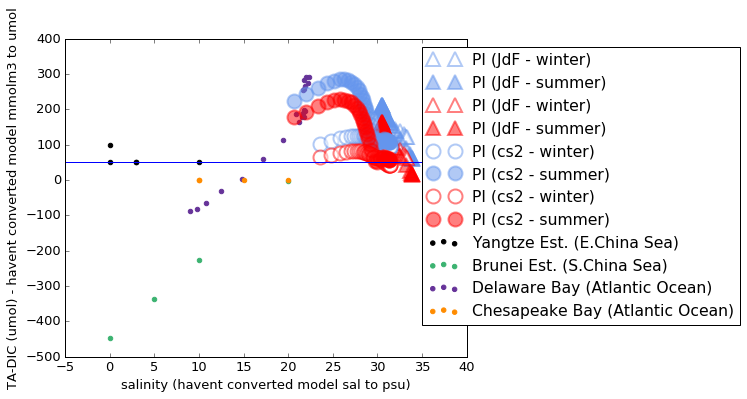

In [114]:


fact = 0.6
fig = plt.figure(figsize=(12*fact, 9.5*fact))

ax1 = plt.subplot(1,1,1)

ax1.scatter(S[pc == 1],TA_DIC[pc == 1], color = 'black', label = 'Yangtze Est. (E.China Sea)')
ax1.scatter(S[pc == 2],TA_DIC[pc == 2], color = 'mediumseagreen', label = 'Brunei Est. (S.China Sea)')
ax1.scatter(S[pc == 3],TA_DIC[pc == 3], color = 'rebeccapurple', label = 'Delaware Bay (Atlantic Ocean)')
ax1.scatter(S[pc == 4],TA_DIC[pc == 4], color = 'darkorange', label = 'Chesapeake Bay (Atlantic Ocean)')

ax1.plot(PI4_sal_jdf_winter,PI4_TA_DIC_jdf_winter, marker = '^', markersize =14,\
         markerfacecolor='white', alpha = 0.5, markeredgecolor='cornflowerblue',\
         markeredgewidth=2 , label = 'PI (JdF - winter) ', linestyle = 'None')
ax1.plot(PI4_sal_jdf_summer,PI4_TA_DIC_jdf_summer, marker = '^', markersize =14,\
         markerfacecolor='cornflowerblue', alpha = 0.5, markeredgecolor='cornflowerblue',\
         markeredgewidth=2 , label = 'PI (JdF - summer) ', linestyle = 'None')
ax1.plot(BR3_sal_jdf_winter,BR3_TA_DIC_jdf_winter, marker = '^', markersize =14,\
         markerfacecolor='white', alpha = 0.5, markeredgecolor='red',\
         markeredgewidth=2 , label = 'PI (JdF - winter) ', linestyle = 'None')
ax1.plot(BR3_sal_jdf_summer,BR3_TA_DIC_jdf_summer, marker = '^', markersize =14,\
         markerfacecolor='red', alpha = 0.5, markeredgecolor='red',\
         markeredgewidth=2 , label = 'PI (JdF - summer) ', linestyle = 'None')
ax1.plot(PI4_sal_cs2_winter,PI4_TA_DIC_cs2_winter, marker = 'o', markersize =14,\
         markerfacecolor='white', alpha = 0.5, markeredgecolor='cornflowerblue',\
         markeredgewidth=2 , label = 'PI (cs2 - winter) ', linestyle = 'None')
ax1.plot(PI4_sal_cs2_summer,PI4_TA_DIC_cs2_summer, marker = 'o', markersize =14,\
         markerfacecolor='cornflowerblue', alpha = 0.5, markeredgecolor='cornflowerblue',\
         markeredgewidth=2 , label = 'PI (cs2 - summer) ', linestyle = 'None')
ax1.plot(BR3_sal_cs2_winter,BR3_TA_DIC_cs2_winter, marker = 'o', markersize =14,\
         markerfacecolor='white', alpha = 0.5, markeredgecolor='red',\
         markeredgewidth=2 , label = 'PI (cs2 - winter) ', linestyle = 'None')
ax1.plot(BR3_sal_cs2_summer,BR3_TA_DIC_cs2_summer, marker = 'o', markersize =14,\
         markerfacecolor='red', alpha = 0.5, markeredgecolor='red',\
         markeredgewidth=2 , label = 'PI (cs2 - summer) ', linestyle = 'None')
ax1.axhline(y=50)
ax1.legend(bbox_to_anchor =[1.7,1])
ax1.set_ylabel('TA-DIC (umol) - havent converted model mmolm3 to umol')
ax1.set_xlabel('salinity (havent converted model sal to psu)')

Text(0.5, 0, 'salinity (havent converted model sal to psu)')

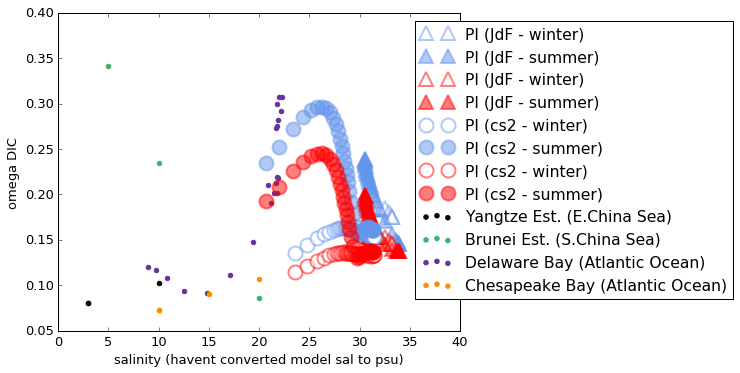

In [115]:


fact = 0.6
fig = plt.figure(figsize=(12*fact, 9.5*fact))

ax1 = plt.subplot(1,1,1)

ax1.scatter(S[pc == 1],-omega_DICs[pc == 1], color = 'black', label = 'Yangtze Est. (E.China Sea)')
ax1.scatter(S[pc == 2],-omega_DICs[pc == 2], color = 'mediumseagreen', label = 'Brunei Est. (S.China Sea)')
ax1.scatter(S[pc == 3],-omega_DICs[pc == 3], color = 'rebeccapurple', label = 'Delaware Bay (Atlantic Ocean)')
ax1.scatter(S[pc == 4],-omega_DICs[pc == 4], color = 'darkorange', label = 'Chesapeake Bay (Atlantic Ocean)')

ax1.plot(PI4_sal_jdf_winter,-PI4_omega_DIC_jdf_winter, marker = '^', markersize =14,\
         markerfacecolor='white', alpha = 0.5, markeredgecolor='cornflowerblue',\
         markeredgewidth=2 , label = 'PI (JdF - winter) ', linestyle = 'None')
ax1.plot(PI4_sal_jdf_summer,-PI4_omega_DIC_jdf_summer, marker = '^', markersize =14,\
         markerfacecolor='cornflowerblue', alpha = 0.5, markeredgecolor='cornflowerblue',\
         markeredgewidth=2 , label = 'PI (JdF - summer) ', linestyle = 'None')
ax1.plot(BR3_sal_jdf_winter,-BR3_omega_DIC_jdf_winter, marker = '^', markersize =14,\
         markerfacecolor='white', alpha = 0.5, markeredgecolor='red',\
         markeredgewidth=2 , label = 'PI (JdF - winter) ', linestyle = 'None')
ax1.plot(BR3_sal_jdf_summer,-BR3_omega_DIC_jdf_summer, marker = '^', markersize =14,\
         markerfacecolor='red', alpha = 0.5, markeredgecolor='red',\
         markeredgewidth=2 , label = 'PI (JdF - summer) ', linestyle = 'None')
ax1.plot(PI4_sal_cs2_winter,-PI4_omega_DIC_cs2_winter, marker = 'o', markersize =14,\
         markerfacecolor='white', alpha = 0.5, markeredgecolor='cornflowerblue',\
         markeredgewidth=2 , label = 'PI (cs2 - winter) ', linestyle = 'None')
ax1.plot(PI4_sal_cs2_summer,-PI4_omega_DIC_cs2_summer, marker = 'o', markersize =14,\
         markerfacecolor='cornflowerblue', alpha = 0.5, markeredgecolor='cornflowerblue',\
         markeredgewidth=2 , label = 'PI (cs2 - summer) ', linestyle = 'None')
ax1.plot(BR3_sal_cs2_winter,-BR3_omega_DIC_cs2_winter, marker = 'o', markersize =14,\
         markerfacecolor='white', alpha = 0.5, markeredgecolor='red',\
         markeredgewidth=2 , label = 'PI (cs2 - winter) ', linestyle = 'None')
ax1.plot(BR3_sal_cs2_summer,-BR3_omega_DIC_cs2_summer, marker = 'o', markersize =14,\
         markerfacecolor='red', alpha = 0.5, markeredgecolor='red',\
         markeredgewidth=2 , label = 'PI (cs2 - summer) ', linestyle = 'None')
ax1.legend(bbox_to_anchor =[1.7,1])
ax1.set_ylabel('omega DIC')
#ax1.set_xlim([-5,40])
ax1.set_xlabel('salinity (havent converted model sal to psu)')